Using Grover's Algorithm To Solve a Boolean Satisfiability Problem (Dinner Problem)

In [1]:
import numpy as np
from qiskit.circuit.library import Diagonal
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, DensityMatrix, ScalarOp
from qiskit.visualization import plot_state_qsphere, plot_histogram
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.compiler import transpile, assemble
from qiskit import Aer,execute
import matplotlib.pyplot as plt

In [2]:
# Creating oracle
oracle=QuantumCircuit(5,name='Oracle')

value_list= ['11010','11011','11001','11110','11000'] 
mark_state = [] 
mark_circuit = []
for i in range(len(value_list)):
    mark_state.append(Statevector.from_label(value_list[i])) # Diagonal operator for mark
    mark_circuit.append(Diagonal((-1)**mark_state[i].data))  # Circuit that induces a -1 phase on the marked states
    oracle.append(mark_circuit[i], [0,1,2,3,4])

oracle.draw()

┌───────────┐┌───────────┐┌───────────┐┌───────────┐┌───────────┐
q_0: ┤0          ├┤0          ├┤0          ├┤0          ├┤0          ├
     │           ││           ││           ││           ││           │
q_1: ┤1          ├┤1          ├┤1          ├┤1          ├┤1          ├
     │           ││           ││           ││           ││           │
q_2: ┤2 Diagonal ├┤2 Diagonal ├┤2 Diagonal ├┤2 Diagonal ├┤2 Diagonal ├
     │           ││           ││           ││           ││           │
q_3: ┤3          ├┤3          ├┤3          ├┤3          ├┤3          ├
     │           ││           ││           ││           ││           │
q_4: ┤4          ├┤4          ├┤4          ├┤4          ├┤4          ├
     └───────────┘└───────────┘└───────────┘└───────────┘└───────────┘

In [3]:
# Amplitude amplification using diffuser

amp = QuantumCircuit(5,name='Diffuser')
amp.h([0,1,2,3,4])
amp.x([0,1,2,3,4])
invert_state = Statevector.from_label('11111')
invert_state = Diagonal((-1)**invert_state.data)
amp.append(invert_state,[0,1,2,3,4])
amp.x([0,1,2,3,4])
amp.h([0,1,2,3,4])

amp.draw()

┌───┐┌───┐┌───────────┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤0          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_1: ┤ H ├┤ X ├┤1          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_2: ┤ H ├┤ X ├┤2 Diagonal ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_3: ┤ H ├┤ X ├┤3          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_4: ┤ H ├┤ X ├┤4          ├┤ X ├┤ H ├
     └───┘└───┘└───────────┘└───┘└───┘

In [4]:
# Final Circuit 

grover_circuit = QuantumCircuit(5,5)
grover_circuit.h([0,1,2,3,4])
grover_circuit.append(oracle,[0,1,2,3,4])
grover_circuit.append(amp,[0,1,2,3,4])
grover_circuit.append(oracle,[0,1,2,3,4])
grover_circuit.append(amp,[0,1,2,3,4])

Statevector([-0.08562621-1.64517430e-16j, -0.08562621-5.70308882e-16j,
             -0.08562621-4.59238028e-16j, -0.08562621-5.47310893e-16j,
             -0.08562621-1.81524369e-16j, -0.08562621-4.97960940e-16j,
             -0.08562621-4.86993603e-16j, -0.08562621-5.25327667e-16j,
             -0.08562621-3.42227314e-16j, -0.08562621-5.62145286e-16j,
             -0.08562621-5.23634951e-16j, -0.08562621-6.33539263e-16j,
             -0.08562621-3.31877132e-16j, -0.08562621-5.00810593e-16j,
             -0.08562621-5.62029814e-16j, -0.08562621-5.03945867e-16j,
             -0.08562621-9.25056760e-17j, -0.08562621-4.08091507e-16j,
             -0.08562621-3.14367887e-16j, -0.08562621-3.64276836e-16j,
             -0.08562621-2.58698834e-16j, -0.08562621-3.01049095e-16j,
             -0.08562621-3.10898440e-16j, -0.08562621-2.34740755e-16j,
              0.4005097 +2.19258526e-15j,  0.4005097 +2.54512603e-15j,
              0.4005097 +2.01811652e-15j,  0.4005097 +2.18576796e-15j,
      

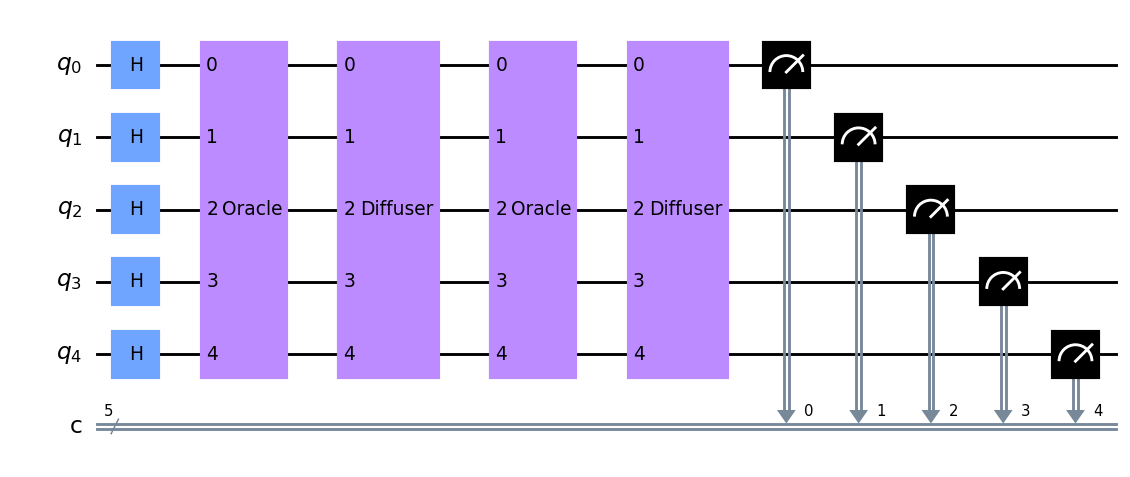

In [5]:
# Running the circuit on a Statevector Simulator Backend to calculate the amplitudes of the state

backend = Aer.get_backend('statevector_simulator')

job = execute(grover_circuit,backend)
result = job.result()
outputstate = result.get_statevector()
print(outputstate)      

grover_circuit.measure([0,1,2,3,4],[0,1,2,3,4])
fig = plt.figure(figsize=(20,15))
grover_circuit.draw(output='mpl', fold=100, ax=fig.gca())  # Final circuit (Image type file)

The counts of the states are stored in counts.txt file.
Histogram of the frequency of the measured state is------>


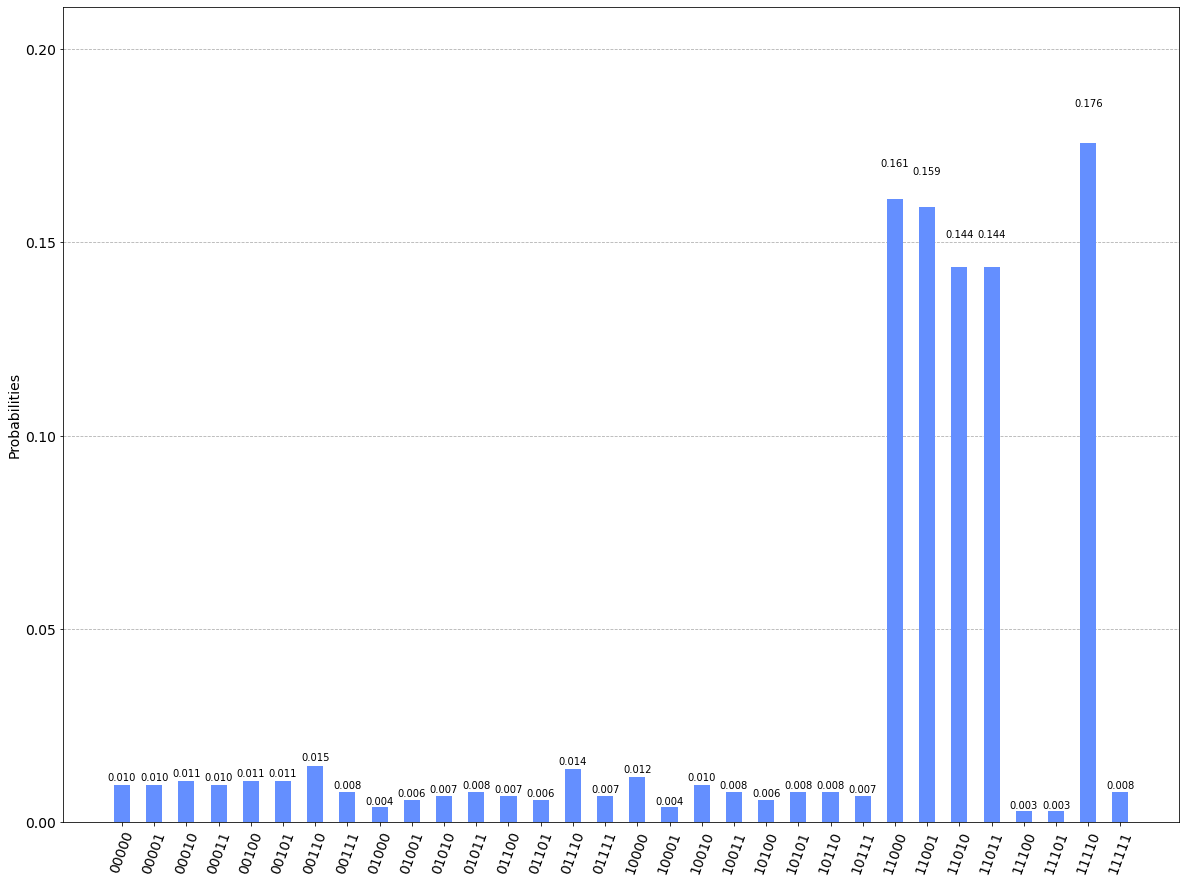

In [6]:
# Using Qasm Simulator to run the algorithm for a sufficient number of counts

backend_sim = Aer.get_backend('qasm_simulator')

# Number of repeats of the circuit= 1024 (default value)
job_sim = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1024)

result_sim = job_sim.result()
counts = result_sim.get_counts(grover_circuit)

print("The counts of the states are stored in counts.txt file.")
with open('counts.txt', 'w') as f:   # Writing counts of the states in a new file 
    for key, value in counts.items():
        f.write('%s : %s\n' % (key, value)) 

print("Histogram of the frequency of the measured state is------>")
from qiskit.visualization import plot_histogram
fig2 = plt.figure(figsize=(20,15))
plot_histogram(counts,ax=fig2.gca())  # Plotting histogram of the frequency of the measured states